In [ ]:
import mlflow
import pandas as pd

uri = ...  # Set your MLflow tracking URI here
mlflow.set_tracking_uri(uri)


# Table - elsa training

In [2]:

run_ids = ['4a43996d7eec489183ad0d6b0c00d935',
           '0c2c7c4b7cd5427db21b9c7022ffbc18']

data = []
runs = [mlflow.get_run(run_id) for run_id in run_ids]
for run in runs: 
    params = run.data.params
    metrics_data = run.data.metrics   
    values = {
        'Dataset': params['dataset'],
        'NDCG@20': metrics_data['NDCG20/test'],
        'Recall@20': metrics_data['R20/test']
    }
    data.append(values)
df = pd.DataFrame(data)
df = df.sort_values(by='NDCG@20', ascending=True).reset_index(drop=True)
df.to_latex(
    'results.tex',
    index=False,
    float_format='%.3f',
    escape=False,
    label='tab:elsa:results',
    caption='Training performance metrics of the ELSA model evaluated on both datasets.'
)

df


,Dataset,NDCG@20,Recall@20
0,MovieLens,0.397809,0.356380
1,LastFM1k,0.495438,0.454723


# Table datasets

In [ ]:
from datasets import MovieLensLoader, LastFm1kLoader

class Config:
    val_ratio = 0.1
    test_ratio = 0.1
    seed = 42
    
movielens = MovieLensLoader()
movielens.prepare(Config())

lastfm = LastFm1kLoader()
lastfm.prepare(Config())

number_of_interactions = lastfm.csr_interactions.data.shape[0] 

In [10]:
import pandas as pd


data = {}
for dataset in [movielens, lastfm]:
    data[dataset.name] = {
        '# Users': len(dataset.users),
        '# Items': len(dataset.items),
        '# Interactions': dataset.csr_interactions.nnz,
        'Sparsity': f'{dataset.csr_interactions.nnz / (len(dataset.users) * len(dataset.items)):.2%}',
        'Average Interactions per User': f'{dataset.csr_interactions.nnz / len(dataset.users):.2f}',
        'Average Interactions per Item': f'{dataset.csr_interactions.nnz / len(dataset.items):.2f}',
    }
    
df = pd.DataFrame(data)
df.to_latex(
    'dataset_stats.tex',
    index=True,
    float_format='%.2f',
    escape=True,
    label='tab:datasets',
    caption='Statistics of the datasets.'
)
df

,MovieLens,LastFM1k
# Users,88897,988
# Items,14069,13794
# Interactions,13034935,607453
Sparsity,1.04%,4.46%
Average Interactions per User,146.63,614.83
Average Interactions per Item,926.50,44.04


# Select the best SAGEA configuration for comparison with other approches

In [32]:
import mlflow
import pandas as pd

experiment_ids = ['523100174176986081', '333391697323445885']
    
group_types = ['sim', 'random', 'outlier']

variants = [
    'average',
    'common_features',
    'max',
    'topk',
    'wcom',
]

runs_to_reuse = []

for exp_id in experiment_ids:
    for group_type in group_types:
        for variant in variants:
            # aggregation, activation = variant
            aggregation = variant
            runs = mlflow.search_runs(
                experiment_ids=[exp_id],
                # filter_string=f"params.SAE_fusion_strategy = '{aggregation}' and params.topk_inference = '{activation}' and params.group_type = '{group_type}'",
                filter_string=f"params.SAE_fusion_strategy = '{aggregation}' and params.group_type = '{group_type}' and params.user_set = 'full' and params.group_set = 'valid'",
                
                output_format="list"
            )
            runs = [run for run in runs if "aggregations" in run.data.params.get("note", "")]
            print(f"Number of runs: {len(runs)}")
            
            runs_metrics = []
            gs = [run.data.metrics.get('CommonItemsNDCG20/mean') for run in runs]
            us = [run.data.metrics.get('NDCG20/min') for run in runs]
            gs_rank = pd.Series(gs).rank(ascending=False, method='min')
            us_rank = pd.Series(us).rank(ascending=False, method='min')
            overall_rank = [g + u for g, u in zip(gs_rank, us_rank)]
            
            best_index = overall_rank.index(min(overall_rank))
            best_run = runs[best_index]
            print(f"Best run ID: {best_run.info.run_id}, G Rank: {gs_rank[best_index]}, G: {gs[best_index]}, U Rank: {us_rank[best_index]}, U: {us[best_index]}, Overall Rank: {overall_rank[best_index]}")
            
            runs_to_reuse.append({
                "sae_fusion_strategy": aggregation,
                "topk_inference": True if best_run.data.params.get("topk_inference") == "True" else False,
                "group_type": group_type,
                "sae_run_id": best_run.data.params.get("sae_run_id"),
                "dataset": best_run.data.params.get("dataset"),
                "user_set": "test",
                "dimensions": best_run.data.params.get("embedding_dim"),
                "k": best_run.data.params.get('top_k')
            })
            print(runs_to_reuse[-1])


Number of runs: 18
Best run ID: 7bd41844b3db45e1a299cec63bdca0f0, G Rank: 1.0, G: 0.6481757760047913, U Rank: 1.0, U: 0.5593137741088867, Overall Rank: 2.0
{'sae_fusion_strategy': 'average', 'topk_inference': True, 'group_type': 'sim', 'sae_run_id': 'b6f471cb3b41454ab2a52932b403ade9', 'dataset': 'MovieLens', 'user_set': 'test', 'dimensions': '1024', 'k': '128'}
Number of runs: 18
Best run ID: 305b1001502948d4ac113ac41a3ac8af, G Rank: 1.0, G: 0.6022070050239563, U Rank: 1.0, U: 0.5237399339675903, Overall Rank: 2.0
{'sae_fusion_strategy': 'common_features', 'topk_inference': False, 'group_type': 'sim', 'sae_run_id': '6820409741044eafb5d1758073ae771e', 'dataset': 'MovieLens', 'user_set': 'test', 'dimensions': '4096', 'k': '64'}
Number of runs: 18
Best run ID: 4a7260cb15934a8d830ee61164f98c1a, G Rank: 2.0, G: 0.6368089318275452, U Rank: 1.0, U: 0.5535297393798828, Overall Rank: 3.0
{'sae_fusion_strategy': 'max', 'topk_inference': True, 'group_type': 'sim', 'sae_run_id': '622c05b8482a4760b

In [33]:
df = pd.DataFrame(runs_to_reuse)
df

renaming = {
    'dataset': "Dataset",
    'group_type': 'Type',
    "sae_fusion_strategy": 'Agg',
    'dimensions': 'Dims',
    "k": 'TopK',
    "topk_inference": "Act",
}

aggregations = {
    "common_features": "ComF",
    "average": "Avg",
    "wcom": "WCom",
    "topk": "TopK",
    "max": "Max",
}

df = df.rename(columns=renaming)[renaming.values()]
df['Agg'] = df['Agg'].apply(lambda x:aggregations[x])
df['Type'] = df['Type'].apply(lambda x: "Similar" if x == 'sim' else "Random" if x == 'random' else 'Outlier')
df = df.sort_values(["Dataset", 'Type', "Agg"], kind = 'stable', ascending=False)

df.to_latex(
    'selection.tex',
    escape=False,
    float_format='%.3f',
    index=False,
    column_format="lll|rrr"
    )

df

,Dataset,Type,Agg,Dims,TopK,Act
4,MovieLens,Similar,WCom,1024,128,False
3,MovieLens,Similar,TopK,2048,128,True
2,MovieLens,Similar,Max,2048,128,True
1,MovieLens,Similar,ComF,4096,64,False
0,MovieLens,Similar,Avg,1024,128,True
9,MovieLens,Random,WCom,4096,128,True
8,MovieLens,Random,TopK,4096,128,True
7,MovieLens,Random,Max,2048,128,True
6,MovieLens,Random,ComF,4096,32,False
5,MovieLens,Random,Avg,1024,64,True


# Evaluate best variants of SAGEA on test set

In [ ]:
import subprocess
        
for run in runs_to_reuse:
    note = "big-fight"
    cmd = [
        'python', 'recommend_sagea.py',
        '--dataset', run['dataset'],
        '--sae_run_id', run['sae_run_id'],
        '--use_base_model_from_sae',
        '--recommender_strategy', 'SAE',
        '--SAE_fusion_strategy', run['sae_fusion_strategy'],
        '--group_type', run['group_type'],
        '--group_size', '3',
        '--user_set', run['user_set'],
        '--note', note,
        '--group_set', 'test',
    ]
    if run['topk_inference']:
        cmd.append('--topk_inference')
    print('Running:', ' '.join(cmd))
    subprocess.run(cmd, check=True)

# Similarity plots

In [ ]:

expriment_ids = ['523100174176986081', '333391697323445885']
import rbo

import numpy as np
import mlflow

def get_runs(group_type, dataset):
    runs = mlflow.search_runs(expriment_ids,
                            filter_string=f"params.group_type = '{group_type}' and params.group_set = 'test' and params.dataset = '{dataset}' and params.user_set = 'full'",
                            output_format="list")
    print(f"Number of runs: {len(runs)}")
    return runs


In [14]:
import pickle

fusion_strategy_mapping = {
    'average': 'Avg',
    'common_features': 'ComF',
    'max': 'Max',
    'topk': 'TopK',
    'wcom': 'WCom',
}

def get_metric_data(runs, order = None):
    recommendations_dict = {}
    for run in runs:
        strategy = run.data.params.get("recommender_strategy")
        if strategy == "SAE":
            fusion_strategy = fusion_strategy_mapping.get(run.data.params.get("SAE_fusion_strategy"), run.data.params.get("SAE_fusion_strategy"))
            strategy += f"-{fusion_strategy}"
            print(strategy)
        artifact_path = run.info.artifact_uri.replace('file://', '') + '/logs.pkl'
        with open(artifact_path, 'rb') as f:
            recommendations = pickle.load(f)["Recommendations"]
        recommendations_dict[strategy] = recommendations

    if order:
        recommendations_dict = {k: recommendations_dict[k] for k in order}
    return recommendations_dict

In [15]:

def get_matrix_from_recommendations(recommendations_dict):
    similarity_matrix = np.zeros((len(recommendations_dict), len(recommendations_dict)))
    for i, rec1 in enumerate(recommendations_dict.values()):
        for j, rec2 in enumerate(recommendations_dict.values()):
            if i == j:
                similarity_matrix[i][j] = 1
            else:
                common_items = []
                for g in range(len(rec1)):
                    rec1_items = rec1[g][:10]
                    rec2_items = rec2[g][:10]
                    # Find items that all 3 users in the group have interacted with
                    # This creates a binary array where a value is 1 if all users interacted with that item
                    ci = len(np.intersect1d(rec1_items, rec2_items)) / len(rec1_items)
                    # ci = rbo.RankingSimilarity(rec1_items[:20], rec2_items[:20]).rbo(p=0.9)
                    common_items.append(ci)
                common_items = np.array(common_items)
                #sanity check
                similarity_matrix[i][j] = np.mean(common_items)
    return similarity_matrix

In [19]:
datasets = ['MovieLens', 'LastFM1k']
group_types = ['sim', 'random', 'outlier']

new_order = [
    'SAE-Avg',
    'SAE-ComF',
    'SAE-Max',
    'SAE-TopK',
    'SAE-WCom',
    'ELSA',
    'ELSA_INT',
    'ADD',
    'LMS',
    'MPL',
    'EPFuzzDA',
    'GFAR',
]

labels = [
    '$\\text{SAGEA}_{\\text{Avg}}$',
    '$\\text{SAE}_{\\text{ComF}}$',
    '$\\text{SAE}_{\\text{Max}}$',
    '$\\text{SAE}_{\\text{TopK}}$',
    '$\\text{SAE}_{\\text{WCom}}$',
    '$\\text{ELSA}_{AVG}$',
    '$\text{ELSA}_{INT}$',
    'ADD',
    'LMS',
    'MPL',
    'EPFuzzDA',
    'GFAR',
]


In [17]:


similarity_matricies = {}
for dataset in datasets:
    for group_type in group_types:
        runs = get_runs(group_type, dataset)
        metrics_data = get_metric_data(runs, order=new_order)
        similarity_matrix = get_matrix_from_recommendations(metrics_data)
        similarity_matricies[(dataset, group_type)] = similarity_matrix
        print(f"Processed {dataset} - {group_type}")


Number of runs: 12
SAE-WCom
SAE-TopK
SAE-Max
SAE-ComF
SAE-Avg
Processed MovieLens - sim
Number of runs: 12
SAE-WCom
SAE-TopK
SAE-Max
SAE-ComF
SAE-Avg
Processed MovieLens - random
Number of runs: 12
SAE-WCom
SAE-TopK
SAE-Max
SAE-ComF
SAE-Avg
Processed MovieLens - outlier
Number of runs: 12
SAE-WCom
SAE-TopK
SAE-Max
SAE-ComF
SAE-Avg
Processed LastFM1k - sim
Number of runs: 12
SAE-WCom
SAE-TopK
SAE-Max
SAE-ComF
SAE-Avg
Processed LastFM1k - random
Number of runs: 12
SAE-WCom
SAE-TopK
SAE-Max
SAE-ComF
SAE-Avg
Processed LastFM1k - outlier


similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)


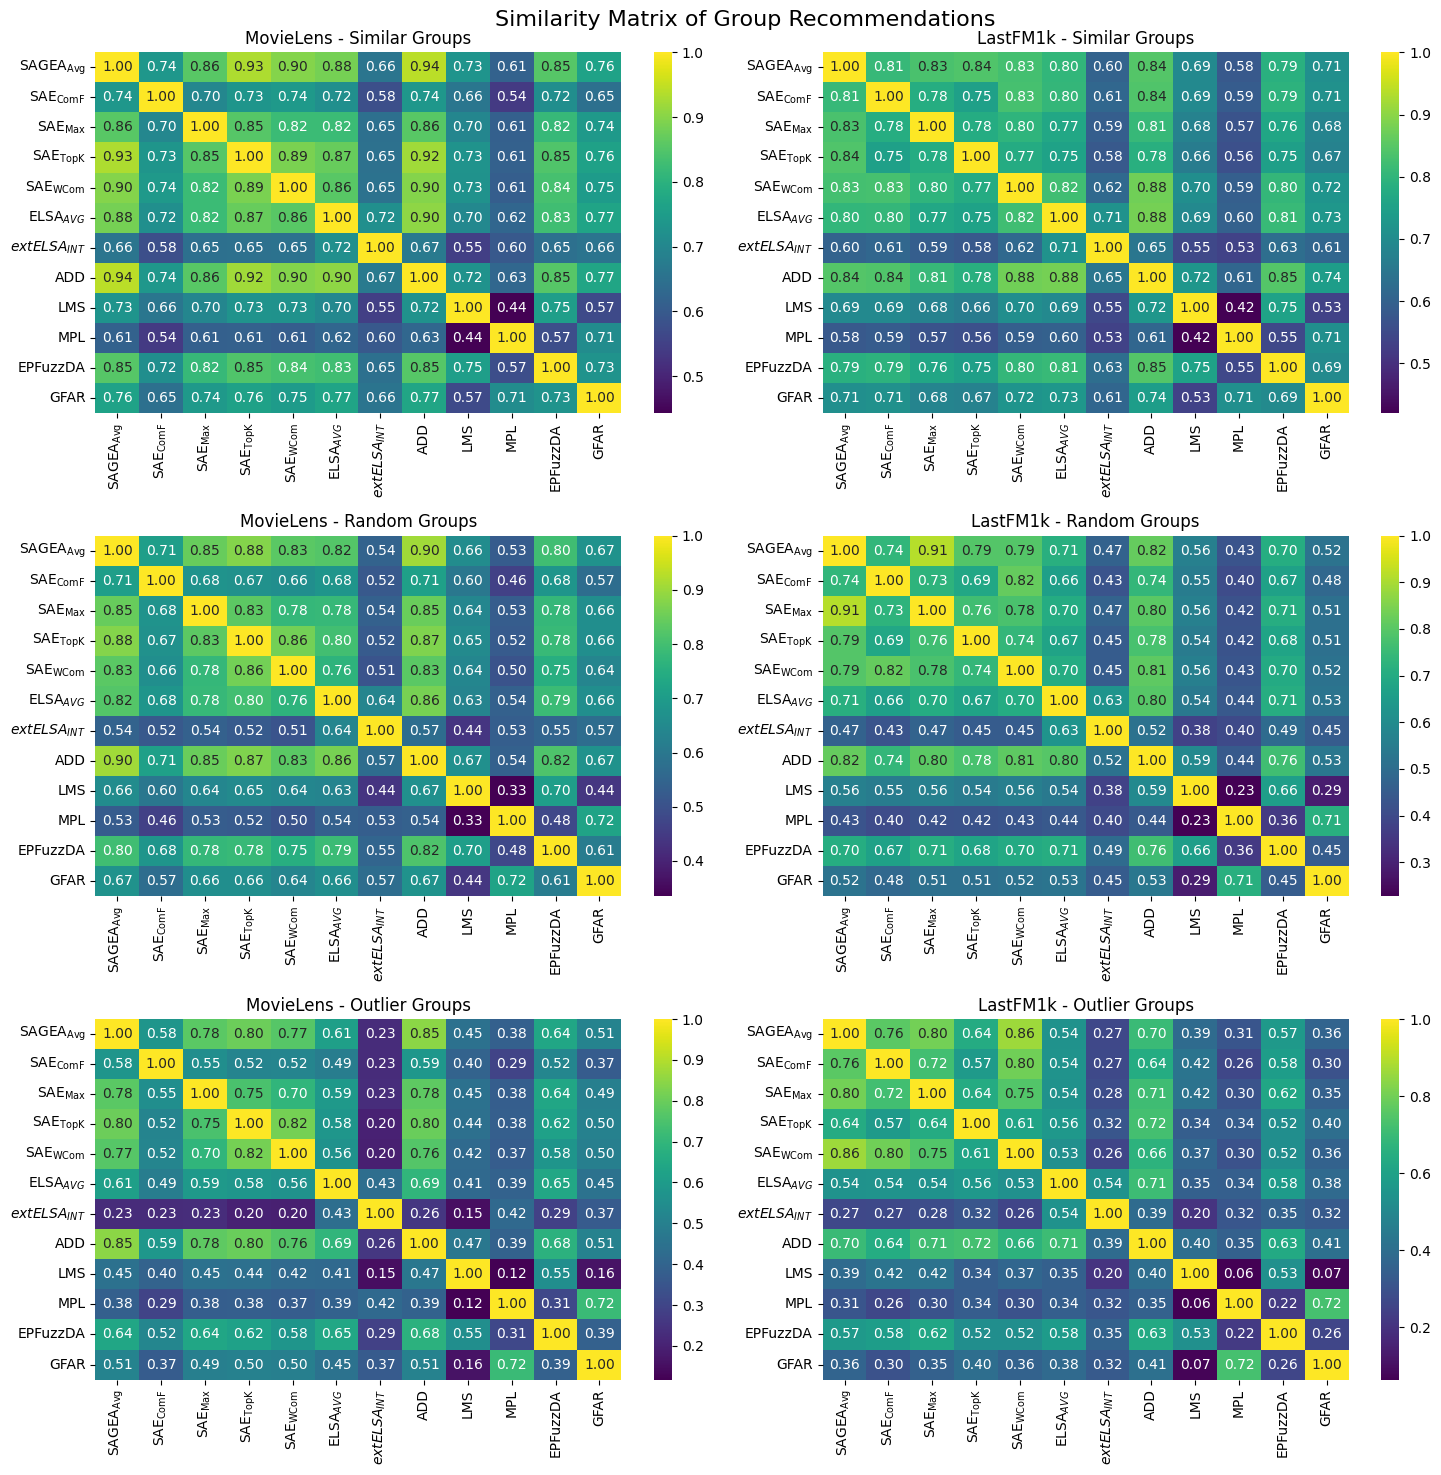

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

group_type_mapping = {
    'sim': 'Similar Groups',
    'random': 'Random Groups',
    'outlier': 'Outlier Groups'
}

fig, axes = plt.subplots(nrows=len(group_types), ncols=len(datasets), figsize=(15, 15))
for i, dataset in enumerate(datasets):
    for j, group_type in enumerate(group_types):
        ax = axes[j, i]
        similarity_matrix = similarity_matricies[(dataset, group_type)]
        print(f"similarity_matrix: {similarity_matrix.shape}")
        df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
        sns.heatmap(df, annot=True, cmap='viridis', fmt=".2f", ax=ax)
        ax.set_title(f"{dataset} - {group_type_mapping[group_type]}")
fig.suptitle('Similarity Matrix of Group Recommendations', fontsize=16)
plt.tight_layout()
plt.savefig('similarity_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

# Significance computation

In [ ]:
aggregation_mapping = {
    "average": "Avg",
    "max": "Max",
    "common_features": "ComF",
    "wcom": "WCom",
    "topk": "TopK",
}

def get_method_name(run):
    params = run.data.params
    method = params.get('recommender_strategy', 'Unknown')
    if method == "SAE":
        aggregation = params.get('SAE_fusion_strategy', 'Unknown')
        method += "-" + aggregation_mapping.get(aggregation, aggregation)
    return method.replace('_', '-')

In [49]:
import pickle

def get_metric_data(runs, metric='NDCG20'):
    metrics_data = {}
    for run in runs:
        strategy = get_method_name(run)
        artifact_path = run.info.artifact_uri.replace('file://', '') + '/logs.pkl'
        with open(artifact_path, 'rb') as f:
            data = pickle.load(f)
        metrics_data[strategy] = data[metric]
    return metrics_data

In [ ]:

metrics = ['Popularity','User_NDCG_Mins', 'User_NDCG_Means', 'Group_NDCG']

for dataset in datasets:
    for group_type in group_types:
        for metric in metrics:
            print(f"Dataset: {dataset}, Group Type: {group_type}, Metric: {metric}")
            runs = get_runs(group_type, dataset)
            metrics_data = get_metric_data(runs, metric=metric)
            sorted_metrics = sorted(metrics_data.items(), key=lambda x: x[1].mean(), reverse=False)
            highest_value_name = sorted_metrics[0][0]
            print(f"Highest value: {highest_value_name} with mean {sorted_metrics[0][1].mean():.3f}")
            metrics_data = {k: v for k, v in sorted_metrics}

            for name, values in metrics_data.items():
                # print(f"{name}: {values.mean():.3f} ± {values.std():.3f} (n={values.shape})")
                t_stat, p_val = stats.ttest_rel(metrics_data[highest_value_name].squeeze(), values.squeeze(), alternative='less')
                print(f"{name}: t = {t_stat:.3f}  p = {p_val:.4f}")
                if p_val >= 0.05:
                    print(f"{name}: NOT SIGNIFICANTLY DIFFERENT")
            print("\n" + "="*50 + "\n")


Dataset: MovieLens, Group Type: sim, Metric: Popularity
Number of runs: 12
Highest value: ELSA-INT with mean 0.427
ELSA-INT: t = nan  p = nan
MPL: t = -6.899  p = 0.0000
GFAR: t = -16.736  p = 0.0000
SAE-ComF: t = -14.010  p = 0.0000
LMS: t = -19.408  p = 0.0000
SAE-WCom: t = -23.287  p = 0.0000
EPFuzzDA: t = -26.547  p = 0.0000
ELSA: t = -33.287  p = 0.0000
SAE-Avg: t = -28.398  p = 0.0000
ADD: t = -29.955  p = 0.0000
SAE-TopK: t = -28.736  p = 0.0000
SAE-Max: t = -30.031  p = 0.0000


Dataset: MovieLens, Group Type: random, Metric: Popularity
Number of runs: 12
Highest value: ELSA-INT with mean 0.414
ELSA-INT: t = nan  p = nan
MPL: t = -11.785  p = 0.0000
GFAR: t = -20.818  p = 0.0000
SAE-ComF: t = -20.167  p = 0.0000
LMS: t = -26.176  p = 0.0000
ELSA: t = -39.689  p = 0.0000
EPFuzzDA: t = -33.069  p = 0.0000
SAE-WCom: t = -31.100  p = 0.0000
SAE-Max: t = -34.775  p = 0.0000
ADD: t = -35.919  p = 0.0000
SAE-Avg: t = -35.092  p = 0.0000
SAE-TopK: t = -36.122  p = 0.0000


Dataset: Mov